#  PIDL solution to PDEs with application to image denoising Implementation

# Important packages and libraries

In [5]:

import numpy as np 
import matplotlib.pyplot as plt
import time
import pandas as pd
import tensorflow as tf
from matplotlib import cm
from scipy.stats import qmc
import os
import cv2
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization,MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Sequential,Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from skimage.color import rgb2gray
from skimage.restoration import denoise_nl_means
from skimage.restoration import denoise_tv_chambolle
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from tabulate import tabulate


In [6]:
#tf.keras.utils.get_custom_objects().update({'psnr': ps

In [7]:
tf.keras.backend.set_floatx("float64")



# Solving heat equation using Finite difference method

In [8]:
# solving 2D heat equation using FDM
# Initial and boundary conditions
max_iter= 1000
lenX=51
lenY=51
dt=1# time steps
Ttop=500
Tbottom=30
Tleft=30
Tright=30 
Tinitial=30
colorinterporation=50

In [9]:
#n=50
#colorinterpolation=50
colourMap=plt.cm.jet
# create a grid    

X, Y = np.meshgrid(np.arange(0,lenX), np.arange(0,lenY))
T= np.empty((lenX,lenY))
T.fill(Tinitial)

# Apply boundary conditions 
T[(lenY-1):,:]= Ttop # Top boundary
T[:1,:] =Tbottom # Bottm boundary
T[:, lenX-1:] = Tright  # right boundayr
T[:,:1] = Tleft#left boundary

In [10]:
#print(T[( lenY-1):,:],T[:1,:],T[:,(lenX-1):],T[:,:1])
#start= time.time()
for iteration in range(0, max_iter):
    T=T.copy()
    for i in range(1,lenX-1,dt):
        for j in range(1,lenX-1,dt):
            T[i,j]=0.25*(T[i+1][j]+T[i-1][j]+T[i][j+1]+T[i][j-1])
print ("the iteration is finished")


the iteration is finished


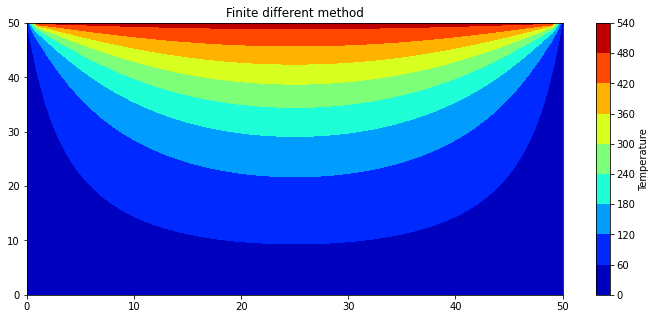

In [11]:

plt.figure(figsize=(12,5))
#plt.subplot(131)
plt.title("Finite different method")
#plt.imshow(T, cmap= colourMap,interpolation='bilinear')
plt.contourf(X,Y,T,cmap=colourMap)
plt.colorbar(label='Temperature')
plt.show()

# Solving heat equation using Finite Difference method second version

In [46]:
max_iter = 1000  # Number of iterations
lenX = 51  # Number of grid points in the x-direction
lenY = 51  # Number of grid points in the y-direction
dt = 1  # Time step
Ttop =  500  # Temperature at the top boundary
Tbottom =30# Temperature at the bottom boundary
Tleft = 30  # Temperature at the left boundary
Tright=30 # Temperature at the right boundary
Tinitial=30 # Temperature initial

In [47]:
def FDM():
    # Create a grid
    x = np.linspace(0, 50, lenX)
    y = np.linspace(0, 50, lenY)
    X, Y = np.meshgrid(x, y)

    # Initialize the temperature matrix
    T = np.ones((lenY, lenX)) * Tinitial

    # Apply boundary conditions
    T[0, :] = Tbottom   # Top boundary
    T[-1, :] = Ttop  # Bottom boundary
    T[:, 0] = Tleft  # Left boundary
    T[:, -1] = Tright  # Right boundary

    # Solve the heat equation iteratively
    for _ in range(max_iter):
        
        T_new = T.copy()
        for i in range(1, lenX - 1):
            for j in range(1, lenY - 1):
                T_new[j, i] = T[j, i] + (dt / (x[i + 1] - x[i - 1]) ** 2) * (
                            T[j, i + 1] - 2 * T[j, i] + T[j, i - 1]) + (
                                          dt / (y[j + 1] - y[j - 1]) ** 2) * (T[j + 1, i] - 2 * T[j, i] + T[j - 1, i])
        T = T_new

    return T


In [48]:
T_final = FDM()
# colourMap=plt.cm.jet


##  Solving 2 dimensional heat equation using finite element method

In [130]:
max_iter = 100  # Number of iterations
lenX = 50  # Number of grid points in the x-direction
lenY = 50  # Number of grid points in the y-direction
dt = 1  # Time step
Ttop =  500  # Temperature at the top boundary
Tbottom =30# Temperature at the bottom boundary
Tleft = 30  # Temperature at the left boundary
Tright=30 # Temperature at the right boundary
Tinitial=30 # Temperature initial

In [162]:
# Initialize temperature matrix
Temp = np.ones((lenX, lenY)) * Tinitial
Temp[0, :] = Ttop
Temp[-1, :] =Tbottom
Temp[:, 0] =Tleft
Temp[:, -1] =Tright

In [163]:
# Create sparse matrix for finite element system
nx = 50
ny = 50
D = 0.25
dy=1
dx=1
A = diags([500, 500, 500, 500, 500], [-nx, 1, 0, 2, nx], shape=(nx*nx, nx*nx)).toarray()
for i in range(nx):
    A[i, i+nx] = -1
    A[i+nx, i] = -1
A

array([[500., 500., 500., ...,   0.,   0.,   0.],
       [  0., 500., 500., ...,   0.,   0.,   0.],
       [  0.,   0., 500., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ..., 500., 500., 500.],
       [  0.,   0.,   0., ...,   0., 500., 500.],
       [  0.,   0.,   0., ...,   0.,   0., 500.]])

In [164]:
# Initialize b and solve finite element system at each time step
# x = np.linspace(0, 50, lenX)
# y = np.linspace(0, 50, lenY)
# X, Y = np.meshgrid(x, y)

b = np.zeros((nx * ny, 1))
for t in range(max_iter):
    Temp[0, :] = Ttop
    Temp[-1, :] = Tbottom
    Temp[:, 0] = Tleft
    Temp[:, -1] = Tright
    b[0:nx,:] += D * (dt / dy ** 2) * Temp[1, 0:nx].reshape(-1, 1)
    b[(ny - 1) * nx :] += D * (dt / dy ** 2) * Temp[-1, 0:ny].reshape(-1, 1)
    b[::nx] += D * (dt / dx ** 2 )* Temp[0:nx, 1].reshape(-1, 1)
    b[nx - 1 :: nx] += D * (dt / dx ** 2) * Temp[0:nx, -2].reshape(-1, 1)
    b += (1 - 2 * D * (dt / dx ** 2 )- 2 * (D * dt / dy ** 2) )* Temp[0:nx, 0:nx].reshape(-1, 1)
    Temp[0:ny, 0:nx] = np.linalg.solve(A, b).reshape((nx, ny ))

# Plotting results

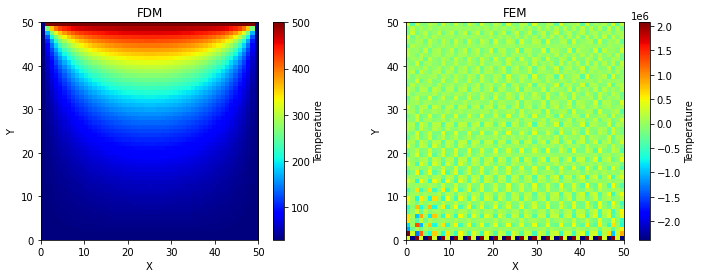

In [166]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.imshow(T_final, cmap=plt.cm.jet, origin='lower', extent=[0, 50, 0, 50])
plt.colorbar(label='Temperature')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('FDM')


plt.subplot(122)
plt.imshow(Temp, cmap=plt.cm.jet, origin='lower', extent=[0, 50, 0, 50])
plt.colorbar(label='Temperature')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('FEM')
plt.show()

# Spectral collocation 

In [183]:
# # Define the spectral differentiation matrix
def D2(N):
    D = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            if i == j:
                D[i, j] = -2
            elif np.abs(i-j) == 1:
                D[i, j] = 1
                D[0, 0] = D[N-1, N-1] = 1
    return D

In [184]:
def solve_heat_equation_2D():
    Temp_top = 500 
    Temp_bottom =30
    Temp_left = 30
    Temp_right = 30
    Temp_initial = 30
    alpha =3
    nx = 50
    ny = 50
    dx = 0.5
    dy = 0.5
    dt = dx**2 / (4 * alpha)
    #nt = int(np.ceil(0.1 / dt))
    nt =1000

    # Initialize the temperature matrix
    Temp1 = np.ones((ny, nx)) * Temp_initial
    Temp1[0, :] = Temp_bottom
    Temp1[-1, :] = Temp_top
    Temp1[:, 0] = Temp_left
    Temp1[:, -1] = Temp_right

    # Create the grid
    x = np.linspace(0, 50, nx)
    y = np.linspace(0, 50, ny)
    X, Y = np.meshgrid(x, y)

    # Create the spectral differentiation matrices
#     D2x = get_chebyshev_differentiation_matrix(nx-1, 2) / Lx**2
#     D2y = get_chebyshev_differentiation_matrix(ny-1, 2) / Ly**2
    D2x =D2(nx)/dx**2
    D2y =D2(ny)/dy**2
    # Time integration
    for n in range(nt):
        # Compute the Laplacian
        Laplacian = D2x.dot(Temp1) + Temp1.dot(D2y)
        Laplacian[0, :] = (Temp1[1, :] -Temp1[0, :]) / dy**2
        Laplacian[-1, :] = (Temp1[-2, :] -Temp1[-1, :]) / dy**2
        Laplacian[:, 0] = (Temp1[:, 1] - Temp1[:, 0]) / dx**2
        Laplacian[:, -1] = (Temp1[:, -2] -Temp1[:, -1]) / dx**2

        # Update the temperature
        Temp1 += alpha * dt * Laplacian

    return Temp1
#Temp_initial, Temp_top, Temp_bottom, Temp_left, Temp_right, alpha, nx, ny

In [194]:
# Test the fanction
# nx=50
# ny=50
# x = np.linspace(0, 50, nx)
# y = np.linspace(0, 50, ny)
x = np.linspace(0, 50, nx)  # Cell-centered x-coordinates
y = np.linspace(0, 50, ny)  # Cell-centered y-coordinates
X, Y = np.meshgrid(x, y)

Temp1 =solve_heat_equation_2D()


# Finite Volume method

In [195]:
# Parameters
Lx = 1.0  # Length of the domain in the x-direction
Ly = 1.0  # Length of the domain in the y-direction
Nx = 50   # Number of control volumes in the x-direction
Ny = 50   # Number of control volumes in the y-direction
alpha = 2
# Initial and boundary conditions
Ttop =  500  # Temperature at the top boundary
Tbottom =30# Temperature at the bottom boundary
Tleft = 30  # Temperature at the left boundary
Tright=30 # Temperature at the right boundary
Tinitial=30
# Grid generation
dx = Lx / Nx-1
dy = Ly / Ny-1
x = np.linspace(0, 50, Nx)  # Cell-centered x-coordinates
y = np.linspace(0, 50, Ny)  # Cell-centered y-coordinates
X, Y = np.meshgrid(x, y)


In [196]:
# Time parameters
t_start = 0.0
t_end = 1.0
dt = 0.001
nt = int((t_end - t_start) / dt) ## number of times

In [197]:
# Initial condition
T = np.ones((Ny, Nx)) * Tinitial

# Boundary conditions
T[:, 0] = Tleft     # Left boundary
T[:, -1] = Tright  # Right boundary
T[0, :] = Tbottom     # Top boundary
T[-1, :] = Ttop # Bottom boundary

In [198]:
# Perform time marching
for t in range(nt):
    # Compute fluxes
    Fx = alpha * (T[1:-1, :-2] - 2*T[1:-1, 1:-1] + T[1:-1, 2:]) / dx**2
    Fy = alpha * (T[:-2, 1:-1] - 2*T[1:-1, 1:-1] + T[2:, 1:-1]) / dy**2
    
    # Update the temperature
    T[1:-1, 1:-1] += dt * (Fx + Fy)


# Plotting the results

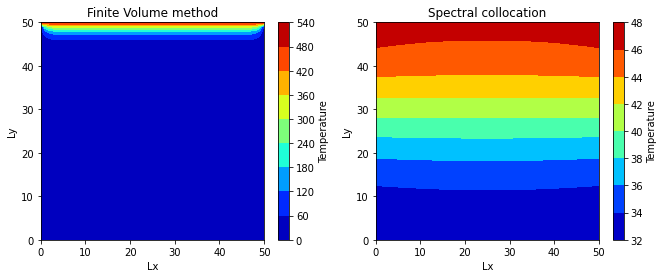

In [199]:
# plot for Finite volume method
plt.figure(figsize=(17,4))
plt.subplot(131)
plt.contourf(X,Y,T,extent=[0, 50, 0, 50], origin='lower', cmap= colourMap)
plt.colorbar(label='Temperature')
plt.xlabel('Lx')
plt.ylabel('Ly')
plt.title('Finite Volume method')

plt.subplot(132)
plt.contourf(X,Y,Temp1, cmap=colourMap, extent=[0, 50, 0, 50], origin='lower')
plt.colorbar(label='Temperature')
plt.title("Spectral collocation")
plt.xlabel('Lx')
plt.ylabel('Ly')
plt.show()


# Solving 2D heat equation using PIDL

In [200]:
@tf.function
def u(x, y):
    u = model(tf.concat([x, y], axis=1))
    return u
     
    

In [201]:


@tf.function
def f(x, y):
    alpha= 0.05
    u0 = u(x, y)
    u_x = tf.gradients(u0, x)[0]
    u_y = tf.gradients(u0, y)[0]
    u_xx = tf.gradients(u_x, x)[0]
    u_yy = tf.gradients(u_y, y)[0]
    F =  alpha*(u_xx + u_yy)
    return tf.reduce_mean(tf.square(F))
     


In [202]:
@tf.function
def mse(y, y_):
    return tf.reduce_mean(tf.square(y-y_))

In [203]:
### model builder function
def DNN_builder(in_shape=2, out_shape=1, n_hidden_layers=10, 
                neuron_per_layer=20
                , actfn="relu"):
    # input layer
    input_layer = tf.keras.layers.Input(shape=(in_shape,))
    # hidden layers
    hidden = [tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(input_layer)]
    for i in range(n_hidden_layers-1):
        new_layer = tf.keras.layers.Dense(neuron_per_layer,
                                          activation=actfn,
                                          activity_regularizer=None)(hidden[-1])
        hidden.append(new_layer)
    # output layer
    output_layer = tf.keras.layers.Dense(1, activation=None)(hidden[-1])
    # building the model
    name = f"DNN-{n_hidden_layers}"
    model = tf.keras.Model(input_layer, output_layer, name=name)
    return model

Model: "DNN-10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 20)                60        
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 20)                420       
                                                                 
 dense_4 (Dense)             (None, 20)                420       
                                                                 
 dense_5 (Dense)             (None, 20)                420  

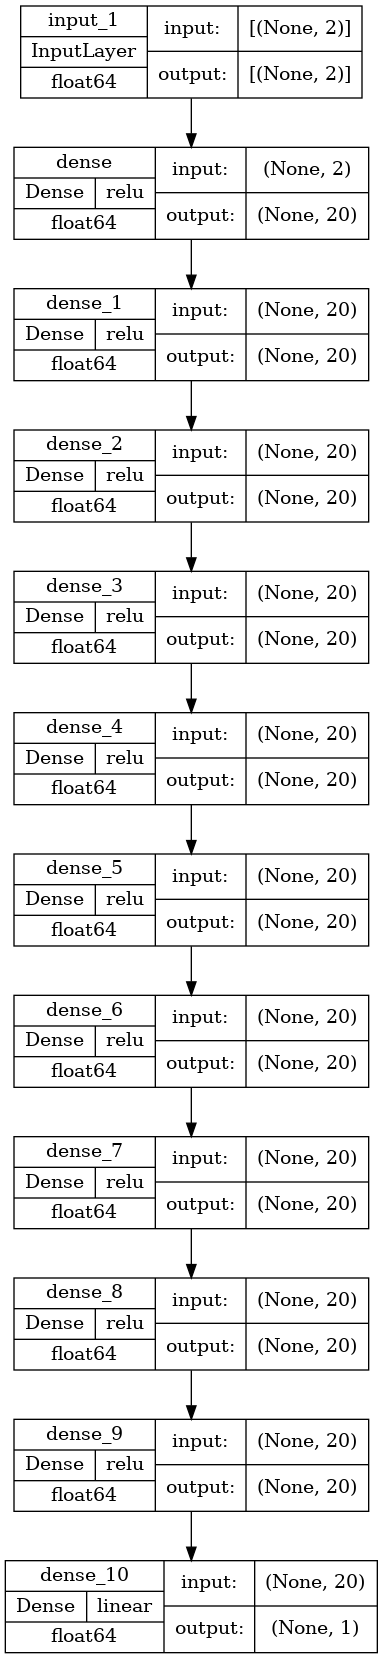

In [204]:
tf.keras.backend.clear_session()
model = DNN_builder(2, 1, 10,20, "relu")
model.summary()
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, 
                          show_layer_names=True, show_dtype=True, 
                          show_layer_activations=True)

In [205]:
# Define the number of boundary conditions and data points per boundary

# Define the boundary conditions
# Left and right boundaries have temperature 30
# Top boundary has temperature 500
# Bottom boundary has temperature 30
n_bc = 4
n_data_per_bc = 45

bc_values = np.array([[30.0, 30.0], [500.0, 500.0], [30.0, 30.0], [30.0, 30.0]])

# Define the Latin Hypercube Sampler
engine = qmc.LatinHypercube(d=2)

# Generate the data
data = np.zeros([4, n_data_per_bc, 3])

for i in range(n_bc):
    # Generate random points using the Latin Hypercube Sampler
    points = engine.random(n=n_data_per_bc)
#     for i, j in zip(range(n_bc), [-1, +1, -1, +1]):
#     points = (engine.random(n=n_data_per_bc)[:, 0] - 0.5) * 2
    # Map the points to the correct coordinates based on the boundary
    if i == 0:
        x = np.zeros(n_data_per_bc)
        y = points[:, 0] * 50.0
    elif i == 1:
        x = points[:, 0] * 50.0
        y = np.ones(n_data_per_bc) * 50.0
    elif i == 2:
        x = np.ones(n_data_per_bc) * 50.0
        y = points[:, 0] * 50.0
    else:
        x = points[:, 0] * 50.0
        y = np.zeros(n_data_per_bc)

# # BC Values
# # normalized in [0, 1]
# data[0, :, 2] = 1.
# data[2, :, 2] = 50/75

# data = data.reshape(n_data_per_bc * n_bc, 3)
    
#     # Store the data in the correct format
    data[i, :, 0] = x
    data[i, :, 1] = y
    data[i, :, 2] = bc_values[i, 0] + (bc_values[i, 1] - bc_values[i, 0]) * points[:, 1]

# Flatten the data and shuffle it
data = data.reshape(n_data_per_bc * n_bc, 3)
np.random.shuffle(data)

# Split the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [206]:
x_d, y_d, t_d = map(lambda x: np.expand_dims(x, axis=1), 
                    [data[:, 0], data[:, 1], data[:, 2]])

#

Nc = 40000
engine = qmc.LatinHypercube(d=2)
colloc = engine.random(n=Nc)
colloc = 50* (colloc -0.013)
#
x_c, y_c = map(lambda x: np.expand_dims(x, axis=1), 
               [colloc[:, 0], colloc[:, 1]])

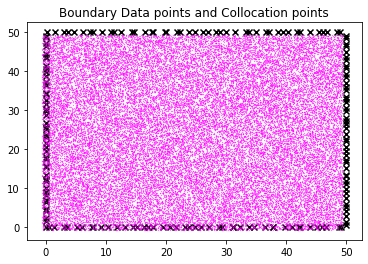

In [207]:
#print(data[:,0], data[:,1])
plt.title("Boundary Data points and Collocation points")
plt.scatter(data[:,0], data[:,1], marker="x", c="k", label="BDP")
plt.scatter(colloc[:,0], colloc[:,1], s=.2, marker=".", c="magenta", label="CP")
# colourMap=plt.cm.jet
# colorinterpolation=50
# plt.contourf(data, colorinterpolation,cmap=colourMap)
plt.show()


In [ ]:
epochs_list0 = 10
#for i, epochs in enumerate (epochs_list):
loss_history = []
loss = 0
opt = tf.keras.optimizers.Adam(learning_rate=3e-4)
#epoch = 0
loss_values = np.array([])
# Train the model for the current epoch value
for epoch in range(epochs_list0):
    with tf.GradientTape() as tape:
        T_ = u(x_d, y_d)
        L = f(x_c, y_c)
        l = mse(t_d, T_)
        loss = l+L
    g = tape.gradient(loss, model.trainable_variables)
    trainable_vars = [var for var, grad in zip(model.trainable_variables, g) if grad is not None]
    grads = [grad for grad in g if grad is not None]
    opt.apply_gradients(zip(grads, trainable_vars))
    loss_values = np.append(loss_values, loss)
    loss_history.append(loss.numpy())

In [209]:
epochs_list = 100
#for i, epochs in enumerate (epochs_list):
loss_history = []
loss = 0
opt = tf.keras.optimizers.Adam(learning_rate=3e-4)
#epoch = 0
loss_values = np.array([])
# Train the model for the current epoch value
for epoch in range(epochs_list):
    with tf.GradientTape() as tape:
        T_ = u(x_d, y_d)
        L = f(x_c, y_c)
        l = mse(t_d, T_)
        loss = l+L
    g = tape.gradient(loss, model.trainable_variables)
    trainable_vars = [var for var, grad in zip(model.trainable_variables, g) if grad is not None]
    grads = [grad for grad in g if grad is not None]
    opt.apply_gradients(zip(grads, trainable_vars))
    loss_values = np.append(loss_values, loss)
    loss_history.append(loss.numpy())

In [210]:
epochs_list1 = 200
# #for i, epochs in enumerate (epochs_list):
loss_history = []
loss = 0
opt = tf.keras.optimizers.Adam(learning_rate=3e-4)
# #epoch = 0
loss_values = np.array([])
# # Train the model for the current epoch value
for epoch in range(epochs_list1):

    with tf.GradientTape() as tape:
        T_ = u(x_d, y_d)
        L = f(x_c, y_c)
        l = mse(t_d, T_)
        loss = l+L
    g = tape.gradient(loss, model.trainable_variables)
    trainable_vars = [var for var, grad in zip(model.trainable_variables, g) if grad is not None]
    grads = [grad for grad in g if grad is not None]
    opt.apply_gradients(zip(grads, trainable_vars))
    loss_values = np.append(loss_values, loss)
    loss_history.append(loss.numpy())

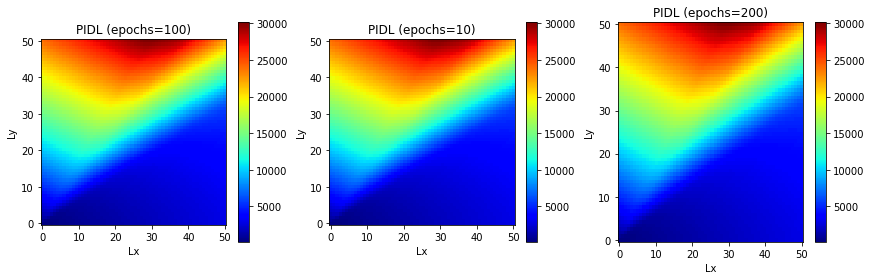

In [211]:
    # Calculate and plot the predicted value for the current epoch value
n=60
X = np.linspace(0, 50, n)
Y = np.linspace(0, 50, n)
X0, Y0 = np.meshgrid(X, Y)
X = X0.reshape([n*n, 1])
Y = Y0.reshape([n*n, 1])
X_T = tf.convert_to_tensor(X)
Y_T = tf.convert_to_tensor(Y)
S = u(X_T, Y_T)
S = S.numpy().reshape(n, n)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.pcolormesh(X0, Y0, 75.*S, cmap="jet")
plt.colorbar()
plt.xlabel("Lx")
plt.ylabel("Ly")
plt.title(f"PIDL (epochs={epochs_list})")
plt.tight_layout()
plt.axis("square")



plt.subplot(1, 3, 2)
plt.pcolormesh(X0, Y0, 75.*S, cmap="jet")
plt.colorbar()
plt.xlabel("Lx")
plt.ylabel("Ly")
plt.title(f"PIDL (epochs={epochs_list0})")
plt.tight_layout()
plt.axis("square")


plt.subplot(1, 3, 3)
plt.pcolormesh(X0, Y0, 75.*S, cmap="jet")
plt.colorbar()
plt.xlabel("Lx")
plt.ylabel("Ly")
plt.title(f"PIDL (epochs={epochs_list1})")
# plt.tight_layout()
# plt.axis("square")


plt.show()



# Show the plot for the current epoch value
#plt.savefig("PIDL_heat.png") d

     

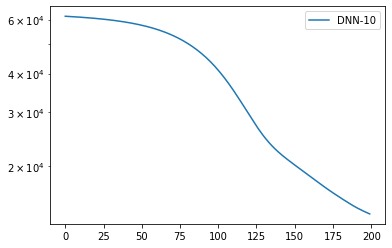

In [212]:
plt.semilogy(loss_values, label=model.name)
plt.legend()
plt.show()

TypeError: Shapes of x (3600, 1) and z (50, 50) do not match

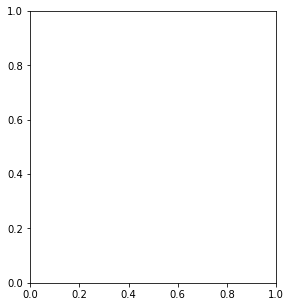

In [213]:
# #ploting the results
plt.figure(figsize=(15,5))
# plt.subplot(131)
# plt.title("Finite different method")
# #plt.imshow(T, cmap= colourMap,interpolation='bilinear')
# plt.contourf(T,cmap=colourMap)
# plt.colorbar()
# #end=time.time()
# #computational_time= end-start
# plt.subplot(132)
#plt.contourf(Temp, cmap=colourMap)
#plt.colorbar()
# plt.title("Finite element method")
# #=time.time()
# #computational_time= end-start
plt.subplot(133)
# # color_interpolation = 50
# # colourMap = plt.cm.jet
plt.contourf(X,Y,Temp1, cmap=colourMap, extent=[0, 50, 0, 50], origin='lower')
plt.colorbar(label='Temperature')
plt.title("Spectral collocation")
plt.show()
#plt.plot(X,Y)
#plt.show()

#plt.savefig('traditional methods.jpg')

# Image denoising with finite difference method

##  Using Isotropic diffusion

# Adding gsusian noise to a clean-image

In [172]:
# Load the image
img0= cv2.imread('/home/user/Desktop/AIMS Folder/Research/notebooks/orginal.png')
img2=cv2.cvtColor(img0,cv2.COLOR_BGR2RGB)

# Convert the image to grayscale
clean_image = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
# plt.imshow( clean_image, cmap="gray")
# plt.axis('off')
# plt.show()

In [173]:
# Define the mean and standard deviation of the Gaussian distribution
mean = 0
stddev = 25

# Generate the Gaussian noise
noise = np.random.normal(mean, stddev,clean_image .shape)

# Add the noise to the image
noisy_image1 = cv2.add(clean_image.astype(np.float64), noise)

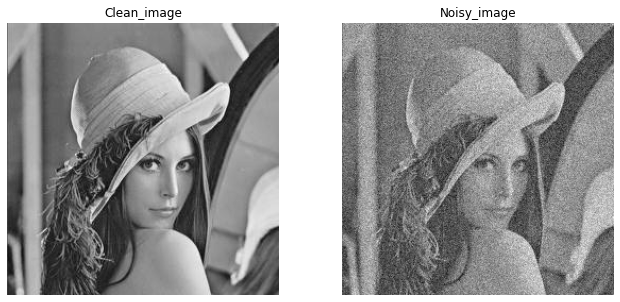

In [175]:
plt.figure(figsize=(11,11))
plt.subplot(221)
plt.imshow( clean_image, cmap="gray")
plt.title("Clean_image")
plt.axis('off')
plt.subplot(222)
plt.imshow(noisy_image1, cmap='gray')
plt.title("Noisy_image")
plt.axis("off")
plt.show()
#plt.savefig("Adding_noise")
             

In [176]:
# isotropic diffusion

# Set the thermal diffusivity and time step
alpha = np.random.randint(0,1)
delta_t = 1

# Set the spatial step
delta_x = 1
delta_y =1

# Set the number of iterations
num_iterations = 500

# Initialize the temperature distribution as the initial image
u = noisy_image1

# Apply the finite difference method to solve the heat equation
for i in range(num_iterations):
    # Compute the Laplacian using central differences
    laplacian = cv2.Laplacian(u, cv2.CV_64F, ksize=3) / (delta_x**2 + delta_y**2)
    
    # Update the temperature distribution using the heat equation
    u = u + alpha * laplacian*delta_t
    Noise_free_img= u.astype(np.float64)
    denoised_image0 = denoise_nl_means(Noise_free_img, h=19)

# Save the final temperature distribution as an image
#v2.imwrite('temperature.pg', u.astype(np.uint8))
#cv2.imwrite(images+f'freenoise{alpha}.png', u.astype(np.uint8))
# plt.imshow( Noise_free_img,cmap='gray')
# plt.axis('off')
# plt.show()

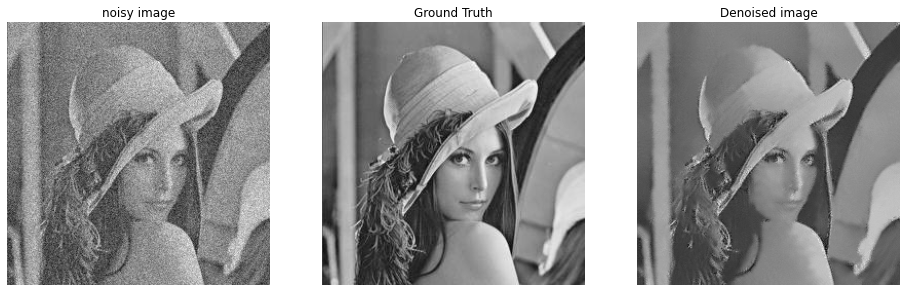

<Figure size 432x288 with 0 Axes>

In [177]:
plt.figure(figsize=(16, 6))
plt.subplot(131)
plt.imshow( noisy_image1, cmap='gray')
plt.title('noisy image')
plt.axis('off')
plt.subplot(132)
plt.imshow(clean_image, cmap='gray')
plt.title('Ground Truth')
plt.axis('off')
plt.subplot(133)
plt.imshow(  denoised_image0, cmap='gray')
plt.axis('off')
plt.title('Denoised image')
plt.show()
plt.savefig('PIDL.jpg')

# Denoising image using PIDL (Convolutional networks)

In [21]:
# img=cv2.imread('/home/user/Desktop/AIMS Folder/Research/notebooks/add noise image.png')
# img1=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
# gray_img = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
# images = '/home/user/Desktop/AIMS Folder/Research/Images/'

# Define the 2D heat equation as a custom loss function
def heat_loss(y_true, y_pred):
    # Define the Laplacian operator using finite differences
    dx = 0.5
    dy = 0.5
    #Alpha= np.random.normal(0, 1)
    u_xx= (tf.constant([[0.0, 1.0, 0.0],
                         [1.0, -4.0, 1.0],
                         [0.0, 1.0, 0.0]], dtype=tf.float64) / dx**2)
    u_yy = (tf.constant([[0.0, 1.0, 0.0],
                         [1.0, -4.0, 1.0],
                         [0.0, 1.0, 0.0]], dtype=tf.float64) / dy**2)
    laplacian = u_xx+u_yy

    # Compute the Laplacian of the predicted image
    laplacian_pred = tf.nn.conv2d(y_pred, tf.reshape(laplacian, [3, 3, 1,1]), strides=[1, 1, 1, 1], padding='SAME')

    # Compute the data fidelity term
    data_term = tf.reduce_mean(tf.square(y_pred - y_true))

    # Compute the regularization term using the Laplacian operator
    reg_term = tf.reduce_mean(tf.square(laplacian_pred))

    # Combine the two terms to form the loss function
    loss = data_term + reg_term

    return loss

# Load the noisy image and the ground truth clean image
noisy_image = noisy_image1.reshape((256,256,1))
img0= cv2.imread('/home/user/Desktop/AIMS Folder/Research/notebooks/orginal.png')
img2=cv2.cvtColor(img0,cv2.COLOR_BGR2RGB)
clean_image = (cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)).reshape((256,256,1))

In [22]:
# Define the input and output tensors for the network
tf.keras.backend.clear_session()
input_tensor = tf.keras.layers.Input(shape=noisy_image.shape)
output_tensor = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(input_tensor)
output_tensor = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(output_tensor)
output_tensor = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(output_tensor)
output_tensor = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(output_tensor)
output_tensor = tf.keras.layers.Conv2D(1, kernel_size=(3, 3), activation='linear', padding='same')(output_tensor)

# Define the model using the input and output tensors
model = tf.keras.models.Model(inputs=input_tensor, outputs=output_tensor)
opt = tf.keras.optimizers.Adam(learning_rate=5e-4)
# Compile the model using the custom loss function
model.compile(optimizer=opt, loss=heat_loss)
start = time.time()
# Train the model on the noisy image and the ground truth clean image
model.fit(x=np.expand_dims(noisy_image, axis=0), y=np.expand_dims(clean_image.astype(np.float64), axis=0), epochs=15)

# Apply the trained model to denoise the input image
#denoised_image = model.predict(np.expand_dims(denoise_nl_means(noisy_image, h=17), axis=0))[0]
denoised_image = model.predict(np.expand_dims(noisy_image1, axis=0))[0]
end = time.time()
computation_time = end - start
print (computation_time )

Epoch 1/15
1/1 [==============================] - 4s 4s/step - loss: 20699.0698 - accuracy: 0.0000e+00
Epoch 2/15
1/1 [==============================] - 2s 2s/step - loss: 17276.9299 - accuracy: 0.0000e+00
Epoch 3/15
1/1 [==============================] - 2s 2s/step - loss: 14154.8206 - accuracy: 0.0000e+00
Epoch 4/15
1/1 [==============================] - 2s 2s/step - loss: 11551.7256 - accuracy: 0.0000e+00
Epoch 5/15
1/1 [==============================] - 2s 2s/step - loss: 8807.4112 - accuracy: 0.0000e+00
Epoch 6/15
1/1 [==============================] - 2s 2s/step - loss: 6010.1186 - accuracy: 0.0000e+00
Epoch 7/15
1/1 [==============================] - 2s 2s/step - loss: 3601.3054 - accuracy: 0.0000e+00
Epoch 8/15
1/1 [==============================] - 2s 2s/step - loss: 2266.3413 - accuracy: 0.0000e+00
Epoch 9/15
1/1 [==============================] - 2s 2s/step - loss: 2677.6244 - accuracy: 0.0000e+00
Epoch 10/15
1/1 [==============================] - 2s 2s/step - loss: 4230.981

In [23]:
import tensorflow.keras.backend as K

def psnr(clean_image, denoised_image):
    max_pixel = 1.0
    mse = K.mean(K.square((clean_image),tf.float64 - (y_pred),tf.float64))
    psnr = 20 * K.log(max_pixel / K.sqrt(mse)) / K.log(10.0)
    return psnr


In [24]:
tf.keras.backend.clear_session()

input_tensor = tf.keras.layers.Input(shape=noisy_image.shape)
output_tensor = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(input_tensor)
output_tensor = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(output_tensor)
output_tensor = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(output_tensor)
output_tensor = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(output_tensor)
output_tensor = tf.keras.layers.Conv2D(1, kernel_size=(3, 3), activation='linear', padding='same')(output_tensor)

In [25]:
# Define the model using the input and output tensors
model = tf.keras.models.Model(inputs=input_tensor, outputs=output_tensor)
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
# Compile the model using the custom loss function
model.compile(optimizer=opt, loss=heat_loss, metrics=['mse','pnsr'])

In [26]:
def train_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = heat_loss(targets, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [27]:
# #start = time.time()
epochs=20
x = tf.cast(np.expand_dims(noisy_image, axis=0), tf.float64)
y = tf.cast(np.expand_dims(clean_image, axis=0), tf.float64)
for epoch in range(epochs):
    loss = train_step(x, y)
    print(f"Epoch {epoch+1}, Loss: {loss:.5f}")
# # Train the model on the noisy image and the ground truth clean image
model.fit(x, y, epochs=20)

Epoch 1, Loss: 19643.23099
Epoch 2, Loss: 14092.59600
Epoch 3, Loss: 8401.89343
Epoch 4, Loss: 3969.40071
Epoch 5, Loss: 2140.05627
Epoch 6, Loss: 5115.40552
Epoch 7, Loss: 4965.39149
Epoch 8, Loss: 2866.07145
Epoch 9, Loss: 1860.20962
Epoch 10, Loss: 2095.88192
Epoch 11, Loss: 2686.25010
Epoch 12, Loss: 3052.12231
Epoch 13, Loss: 3027.86930
Epoch 14, Loss: 2667.72824
Epoch 15, Loss: 2138.53120
Epoch 16, Loss: 1669.93754
Epoch 17, Loss: 1494.63033
Epoch 18, Loss: 1684.13958
Epoch 19, Loss: 1984.14750
Epoch 20, Loss: 2000.81880
Epoch 1/20


ValueError: in user code:

    File "/home/user/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/user/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/user/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/user/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1055, in train_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/home/user/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1149, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/home/user/.local/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 577, in update_state
        self.build(y_pred, y_true)
    File "/home/user/.local/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 483, in build
        self._metrics = tf.__internal__.nest.map_structure_up_to(
    File "/home/user/.local/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 631, in _get_metric_objects
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    File "/home/user/.local/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 631, in <listcomp>
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    File "/home/user/.local/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 650, in _get_metric_object
        metric_obj = metrics_mod.get(metric)
    File "/home/user/.local/lib/python3.10/site-packages/keras/metrics/__init__.py", line 204, in get
        return deserialize(str(identifier))
    File "/home/user/.local/lib/python3.10/site-packages/keras/metrics/__init__.py", line 158, in deserialize
        return deserialize_keras_object(
    File "/home/user/.local/lib/python3.10/site-packages/keras/saving/legacy/serialization.py", line 543, in deserialize_keras_object
        raise ValueError(

    ValueError: Unknown metric function: 'pnsr'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.


In [ ]:
# Apply the trained model to denoise the input image
denoised_image = model.predict(np.expand_dims(noisy_image, axis=0))[0]

# # Evaluate the performance of the model
# metrics = model.evaluate(x=x, y=y)
# end = time.time()
# computation_time = end - start
# print (computation_time )

#print('MSE:', metrics[1])
#print('PSNR:', metrics[2])

In [ ]:

#denoised_image0 = denoise_nl_means(denoised_image, h=2)

# Plot the results
plt.figure(figsize=(16, 6))
plt.subplot(131)
plt.imshow(noisy_image, cmap='gray')
plt.axis('off')
plt.title('Noisy Image')
plt.subplot(132)
plt.imshow(clean_image, cmap='gray')
plt.title('Ground Truth')
plt.axis('off')
plt.subplot(133)
plt.imshow(denoised_image, cmap='gray')
plt.title('Denoised Image')
plt.axis('off')
plt.show()

In [ ]:
#Lconv_1 = model.layers

# weights, biases =layer.get_weights()
# #biases = model.get_weights()

In [ ]:
## printing weights of the each layer

for layer in model.layers:
    weights = layer.get_weights()
    if len(weights) > 0:
        print(layer.name)
        #print(weights)

In [ ]:
#printing weights for each layer with respect to filters

for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Conv2D):
        weights = layer.get_weights()[0]
        num_filters = weights.shape[3]
        for i in range(num_filters):
            filter_values = weights[:, :, :, i]
            plt.imshow(filter_values)
            plt.show()


In [ ]:
## plot and save the picture of the model
tf.keras.utils.plot_model(model, show_shapes=True)
#plt.savefig('model.jpg')

In [ ]:
import numpy as np
from scipy.fftpack import dctn, idctn

In [ ]:
# Define parameters
Lx = Ly = 1  # Domain size
nx = ny = 32  # Number of grid points
dx = Lx / nx  # Grid spacing
dy = Ly / ny
x = np.linspace(0, Lx, nx, endpoint=False)
y = np.linspace(0, Ly, ny, endpoint=False)
X, Y = np.meshgrid(x, y)

# Set initial conditions
T0 = np.zeros((nx, ny))
T0[nx//4:3*nx//4, ny//4:3*ny//4] = 1

# Define spectral differentiation matrix
kx = np.fft.fftfreq(nx, d=dx) * 2 * np.pi
ky = np.fft.fftfreq(ny, d=dy) * 2 * np.pi
KX, KY = np.meshgrid(kx, ky)
K2 = KX**2 + KY**2
d2dx2 = -KX**2
d2dy2 = -KY**2

In [ ]:
# Time integration
t = 0
t_end = 1
dt = 0.001
while t < t_end:
    # Compute spectral derivatives
    T = dctn(T0)
    d2Tdx2 = idctn(d2dx2 * T)
    d2Tdy2 = idctn(d2dy2 * T)

    # Update temperature field
    T0 += dt * (d2Tdx2 + d2Tdy2)

    # Apply boundary conditions
    T0[0,:] = T0[-1,:] = T0[:,0] = T0[:,-1] = 0

    # Advance time
    t += dt
    

In [ ]:
plt.contourf(T0, cmap=colourMap,interpolation='bilinear')
plt.colorbar()


plt.title("Spectral collocation")

## Anisotropic diffusion

## define diffusivity of the function

In [ ]:
def diff (dt, b):
    y= (1/(1+((dt/b)**2)))
    return y

In [ ]:
def anisodiff(im, steps, b, l = 0.25): 
    temp = np.zeros(im.shape, dtype=im.dtype) 
    for t in range(steps): 
        dn = im[:-2,1:-1] - im[1:-1,1:-1] 
        ds = im[2:,1:-1] - im[1:-1,1:-1] 
        de = im[1:-1,2:] - im[1:-1,1:-1] 
        dw = im[1:-1,:-2] - im[1:-1,1:-1] 
        temp[1:-1,1:-1] = im[1:-1,1:-1] +\
                            l * (diff(dn,b)*dn + diff(ds,b)*ds + 
                                    diff(de,b)*de + diff(dw,b)*dw) 
        im = temp 
    return im

In [ ]:
## denoisin image
Denoised_img = anisodiff(noisy_image1, 13,0.15,l= 0.15)

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(131)
plt.imshow( noisy_image1, cmap='gray')
plt.title('Noisy image')
plt.axis('off')
plt.subplot(132)
plt.imshow(clean_image, cmap='gray')
plt.title('Ground Truth')
plt.axis('off')
plt.subplot(133)
plt.imshow(Denoised_img, cmap='gray')
plt.axis('off')
plt.title('Denoised image')
plt.show()

In [ ]:
from skimage import exposure



# Set the thermal diffusivity and time step
alpha = 0.0003
delta_t = 0.98

# Set the spatial step
delta_x = 1
delta_y =1

# Set the number of iterations
num_iterations = 1000

# Initialize the temperature distribution as the initial image
u = noisy_image1

# Apply the finite difference method to solve the heat equation
# for i in range(num_iterations):
#     # Compute the Laplacian using central differences
#     laplacian = cv2.Laplacian(u, cv2.CV_64F, ksize=3) / (delta_x**2 + delta_y**2)
    
#     # Update the temperature distribution using the heat equation
#     u = u + alpha * laplacian*delta_t
#     Noise_free_img= u.astype(np.float64)
# # Save the final temperature distribution as an image
#v2.imwrite('temperature.pg', u.astype(np.uint8))
#cv2.imwrite(images+f'freenoise{alpha}.png', u.astype(np.uint8))
# Apply anisotropic diffusion
denoised_image = denoise_tv_chambolle(u, weight=0.01, eps=0.0002,max_num_iter=200, channel_axis=None)
#denoised_image = denoise_nl_means(u, h=10)
# # Apply histogram equalization
equalized_image = exposure.equalize_hist(denoised_image)
denoised_image0 = denoise_nl_means(equalized_image, h=20)

In [ ]:

u0=noisy_image1
iterations = 500
diffusivity = lambda x: 1 / (1 + (x / 10)**2)  # Conductance function
dt = 0.001  # Time step
dx = 1  # Spatial step
dy = 1

# Perform non-linear diffusion
for i in range(iterations):
    # Calculate the gradient of the image
    gradient = np.gradient(u0)

    # Calculate the magnitude of the gradient
    magnitude = np.sqrt(gradient[0]**2 + gradient[1]**2)

    # Apply the conductance function to the magnitude
    diffusivity_matrix = diffusivity(magnitude)

    # Calculate the Laplacian of the image
    laplacian = np.gradient(diffusivity_matrix * gradient[0], dy, axis=1) \
                + np.gradient(diffusivity_matrix * gradient[1], dx, axis=0)

    # Update the image using the diffusion equation
    u0+= dt * laplacian
    denoised_image= u0






In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(131)
plt.imshow( noisy_image1, cmap='gray')
plt.title('Noisy image')
plt.axis('off')
plt.subplot(132)
plt.imshow( equalized_image, cmap='gray')
plt.axis('off')
plt.title('Denoised image')
plt.show()

In [ ]:
from scipy.ndimage.filters import laplace
from scipy.ndimage import gaussian_filter

# Define the anisotropic diffusion function
def anisotropic_diffusion(image, n_iter, kappa, gamma):
    # Define the coefficients
    coeff = lambda d: np.exp(-(d/kappa)**2)/gamma

    # Create an empty image
    output = np.zeros_like(image)

    # Iterate over the number of iterations
    for i in range(n_iter):
        # Compute the gradients
        gradients = np.array(np.gradient(output))

        # Compute the norm of the gradients
        norm_gradients = np.sqrt(np.sum(gradients**2, axis=0))

        # Compute the coefficients for each pixel
        c = coeff(norm_gradients)

        # Compute the divergence of the coefficients times the gradients
        divergence = np.array(np.gradient(c*gradients))
        divergence = np.sum(divergence, axis=0)

        # Compute the Laplacian of the image
        laplacian = laplace(output)

        # Compute the output image
        output = output + divergence + kappa*laplacian

        # Apply a Gaussian filter to smooth the output image
        output = gaussian_filter(output, sigma=1)

    return output


In [ ]:
# Load the noisy image
# Denoise the image using anisotropic diffusion
denoised_image = anisotropic_diffusion(noisy_image1, n_iter=10, kappa=30, gamma=0.1)

# Display the denoised image
plt.imshow(denoised_image, cmap='gray')
plt.show()


In [ ]:
# ### data generation
# n_bc = 4
# n_data_per_bc = 25

# #quasi- monte carlo 
# engine = qmc.LatinHypercube(d=1)
# data = np.zeros([4, 25, 3])
# #print(data.shape)

# for i, j in zip(range(n_bc), [-1, +1, -1, +1]):
#     points = (engine.random(n=n_data_per_bc)[:, 0] - 0.5) * 2
#     if i < 2:
#         data[i, :, 0] = j
#         data[i, :, 1] = points
#     else:
#         data[i, :, 0] = points        
#         data[i, :, 1] = j

# # BC Values
# # normalized in [0, 1]
# data[0, :, 2] = 1.
# data[2, :, 2] = 50/75

# data = data.reshape(n_data_per_bc * n_bc, 3)

# # dataset = pd.DataFrame(data)
# # print(dataset)
# # train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)

# #
# x_d, y_d, t_d = map(lambda x: np.expand_dims(x, axis=1), 
#                     [data[:, 0], data[:, 1], data[:, 2]])

# #

# Nc = 40000
# engine = qmc.LatinHypercube(d=2)
# colloc = engine.random(n=Nc)
# colloc = 2 * (colloc -0.5)
# #
# x_c, y_c = map(lambda x: np.expand_dims(x, axis=1), 
#                [colloc[:, 0], colloc[:, 1]])

# #print(data[:,0], data[:,1])
# plt.title("Boundary Data points and Collocation points")
# plt.scatter(data[:, 0], data[:, 1], marker="x", c="k", label="BDP")
# plt.scatter(colloc[:, 0], colloc[:, 1], s=.2, marker=".", c="b", label="CP")
# # colourMap=plt.cm.jet
# # colorinterpolation=50
# # plt.contourf(data, colorinterpolation,cmap=colourMap)
# plt.show()

# #
# print(data)

In [31]:
data_2d = np.concatenate([t.reshape(-1, 1) for t in data], axis=-1).T
# df1 = pd.DataFrame(data_2d)
# df2 = pd.DataFrame(colloc)
# df2

In [32]:
# # Convert the DataFrame to a LaTeX table format using the tabulate function
# latex_table = tabulate(df1, headers='keys', tablefmt='latex')

# # Print the LaTeX code
# print(latex_table)

In [34]:
# # set size and font
# fig.set_size_inches(w=3.27, h=2.5) # set the size to be appropriate for a column in a two-column paper
# plt.rcParams.update({'font.size': 10})

# # save figure as pgf
# fig.savefig('figure.pgf', bbox_inches='tight')

In [37]:
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
# model.compile(loss=tf.keras.losses.mean_squared_error, optimizer=optimizer,
#                    metrics=['accuracy'])

In [41]:
# # Initialize variables and parameters
# epochs_list = [50, 100, 200]  # List of epoch values to iterate through

# # Loop through different epoch values
# for epochs in epochs_list:
#     loss = 0
#     opt = tf.keras.optimizers.Adam(learning_rate=3e-4)
#     epoch = 0
#     loss_values = np.array([])
#     with tf.GradientTape() as tape:
#         T_ = u(x_d, y_d)
#         L = f(x_c, y_c)
#         l = mse(t_d, T_)
#         loss = l+L
#     g = tape.gradient(loss, model.trainable_weights)
#     opt.apply_gradients(zip(g, model.trainable_weights))
#     loss_values = np.append(loss_values, loss)
#     if epoch % 200 == 0 or epoch == epochs-1:
#     print(f"{epoch:5}, {loss.numpy():.3f}")
#     # Your existing code for training and generating predicted value

In [ ]:
# # Initialize variables and parameters
# epochs_list = [50, 100, 200]  # List of epoch values to iterate through
# loss_history = []
# loss = 0
# opt = tf.keras.optimizers.Adam(learning_rate=3e-4)
# #epoch = 0
# loss_values = np.array([])
# # Loop through different epoch values
# for epochs in epochs_list:
#     loss_history = []
#     loss = 0
#     opt = tf.keras.optimizers.Adam(learning_rate=3e-4)
#     #epoch = 0
#     # Train the model for the current epoch value
#     for epoch in range(epochs):
#         with tf.GradientTape() as tape:
#             T_ = u(x_d, y_d)
#             L = f(x_c, y_c)
#             l = mse(t_d, T_)
#             loss = l+L
#         g = tape.gradient(loss, model.trainable_weights)
#         opt.apply_gradients(zip(g, model.trainable_weights))
#         loss_values = np.append(loss_values, loss)
#         loss_history.append(loss.numpy())
#         if epoch % 200 == 0 or epoch == epochs-1:
#             print(f"{epoch:5}, {loss.numpy():.3f}")
# #
# plt.semilogy(loss_values, label=model.name)
# plt.legend()
     

In [ ]:
# #     # Generate predicted value for the current epoch value
# plt.figure("", figsize=(12, 6))
# X = np.linspace(0, 50, n)
# Y = np.linspace(0, 50, n)
# X0, Y0 = np.meshgrid(X, Y)
# X = X0.reshape([n*n, 1])
# Y = Y0.reshape([n*n, 1])
# X_T = tf.convert_to_tensor(X)
# Y_T = tf.convert_to_tensor(Y)
# #S = np.array(T).reshape((len(X0), len(Y0))).T
# S = u(X_T, Y_T)
# S = S.numpy().reshape(n, n)

# # Plot the predicted value for the current epoch value
# plt.subplot(221)
# plt.pcolormesh(X0, Y0, 75.*S, cmap="jet")
# plt.colorbar()
# plt.xlabel("x")
# plt.ylabel("y")
# plt.title(f"PIDL (epochs={epochs})")
# # plt.tight_layout()
# plt.axis("square")

# # Show the plot for the current epoch value
# plt.show()

In [ ]:
### plotting

# plt.figure("", figsize=(12, 6))
# #
# X = np.linspace(0, 50, n)
# Y = np.linspace(0, 50, n)
# X0, Y0 = np.meshgrid(X, Y)
# X = X0.reshape([n*n, 1])
# Y = Y0.reshape([n*n, 1])
# X_T = tf.convert_to_tensor(X)
# Y_T = tf.convert_to_tensor(Y)
# S = u(X_T, Y_T)
# S = S.numpy().reshape(n, n)
# #
# plt.subplot(221)
# plt.pcolormesh(X0, Y0, 75.*S, cmap="jet")
# plt.colorbar()
# plt.xlabel("x")
# plt.ylabel("y")
# plt.title("PIDL")
# plt.tight_layout()
# plt.axis("square")
# #
# x = np.linspace(0, 50, n)
# y = np.linspace(0, 50, n)
# x, y = np.meshgrid(x, y)

# plt.subplot(222)
# plt.pcolormesh(x, y, T, cmap="magma")
# plt.colorbar()
# plt.title(r"FDM")
# plt.xlabel("x")
# plt.ylabel("y")
# plt.xlim(-1, +1)
# plt.ylim(-1, +1)
# plt.tight_layout()
# plt.axis("square")
# plt.savefig("heat01.png")
# #
# plt.subplot(223)
# pinn_grad = np.gradient(np.gradient(S, axis=0), axis=1)
# sigma_pinn = (pinn_grad**2).mean()
# plt.pcolormesh(X0, Y0, pinn_grad, cmap="jet")
# plt.colorbar()
# plt.xlabel("x")
# plt.ylabel("y")
# plt.title(r"" + f"\nmean squared: {sigma_pinn: .3e}")
# plt.tight_layout()
# plt.axis("square")
# ###
# x = np.linspace(-1, +1, n)
# y = np.linspace(-1, +1, n)
# x, y = np.meshgrid(x, y)
# #
# plt.subplot(222)
# fdm_grad = np.gradient(np.gradient(T, axis=0), axis=1)
# sigma_fdm = (fdm_grad**2).mean()
# plt.pcolormesh(x, y, fdm_grad, cmap="jet")
# plt.colorbar()
# plt.title(r"" + f"\nmean squared: {sigma_fdm: .3e}")
# plt.xlabel("x")
# plt.ylabel("y")
# plt.xlim(-1, +1)
# plt.ylim(-1, +1)
# plt.tight_layout()
# plt.axis("square")
# # plt.savefig("heat01.png")
# plt.show()
     


In [ ]:
import numpy as np
import cv2
import tensorflow as tf

# Load the noisy image
noisy_image = cv2.imread('noisy_image.png', cv2.IMREAD_GRAYSCALE)

# Preprocessing
preprocessed_image = noisy_image[10:-10, 10:-10]

# PDE-based denoising
diffusion_coefficient = 0.1
denoised_image_pde = cv2.ximgproc.anisotropicDiffusion(preprocessed_image.astype(np.float32), 
                                                       alpha=diffusion_coefficient, 
                                                       niters=10)

# Training the deep neural network
input_image = tf.keras.layers.Input(shape=(None, None, 1))
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_image)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
output_image = tf.keras.layers.Conv2D(1, (3, 3), activation='relu', padding='same')(x)
model = tf.keras.models.Model(inputs=input_image, outputs=output_image)

model.compile(optimizer='adam', loss='mse')

# Load the training dataset
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'training_data',
    batch_size=32,
    image_size=(256, 256))

# Train the model
model.fit(train_dataset, epochs=10)

# Apply the trained model to the noisy image
denoised_image_dl = model.predict(np.expand_dims(preprocessed_image.astype(np.float32), axis=-1))

# Combining PDE and deep learning
alpha =


# Image denoising without Incorporating physical laws 

In [ ]:
# Load noisy image
noisy_image0 = noisy_image1.reshape((256,256,1))

# Define the input shape
#input_shape = (None, None, 1)

# Define the model architecture
input_tensor = tf.keras.layers.Input(shape=noisy_image0.shape)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

In [ ]:
# x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
# x = UpSampling2D((2, 2))(x)
# x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
# x = UpSampling2D((2, 2))(x)
# x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
# x = UpSampling2D((2, 2))(x)
# decoded = Conv2D(1, (3, 3), activation='relu', padding='same')(x)

# Define the model
model = Model(inputs, decoded)
opt = tf.keras.optimizers.Adam(learning_rate=3e-4)
# Compile the model
model.compile(optimizer=opt, loss='mse')

# Train the model
#model.fit(noisy_image0, clean_image, epochs=10)
model.fit(x=np.expand_dims(noisy_image0, axis=0), y=np.expand_dims(clean_image.astype(np.float64), axis=0), epochs=10)

# Denoise the image
denoised_image0 = model.predict(np.expand_dims(noisy_image0, axis=0))[0]

In [ ]:


# Plot the results
plt.figure(figsize=(16, 6))
plt.subplot(131)
plt.imshow(noisy_image0, cmap='gray')
plt.axis('off')
plt.title('Noisy Image0')
plt.subplot(132)
plt.imshow(clean_image, cmap='gray')
plt.title('Ground Truth')
plt.axis('off')
plt.subplot(133)
plt.imshow(denoised_image0, cmap='gray')
plt.title('Denoised Image')
plt.axis('off')
plt.show()

In [ ]:
noisy_image0.shape

In [ ]:
### data generation
n_bc = 4
n_data_per_bc = 25
#
engine = qmc.LatinHypercube(d=1)
data = np.zeros([4, 25, 3])

for i, j in zip(range(n_bc), [-1, +1, -1, +1]):
    points = (engine.random(n=n_data_per_bc)[:, 0] - 0.5) * 2
    if i < 2:
        data[i, :, 0] = j
        data[i, :, 1] = points
    else:
        data[i, :, 0] = points
        data[i, :, 1] = j

# BC Values
# normalized in [0, 1]
data[0, :, 2] = 1.
data[2, :, 2] = 50/75

data = data.reshape(n_data_per_bc * n_bc, 3)
#
x_d, y_d, t_d = map(lambda x: np.expand_dims(x, axis=1), 
                    [data[:, 0], data[:, 1], data[:, 2]])

#

Nc = 10000
engine = qmc.LatinHypercube(d=2)
colloc = engine.random(n=Nc)
colloc = 2 * (colloc -0.5)
#
x_c, y_c = map(lambda x: np.expand_dims(x, axis=1), 
               [colloc[:, 0], colloc[:, 1]])

#

plt.title("Boundary Data points and Collocation points")
plt.scatter(data[:, 0], data[:, 1], marker="x", c="k", label="BDP")
plt.scatter(colloc[:, 0], colloc[:, 1], s=.2, marker=".", c="r", label="CP")
plt.show()

#

x_c, y_c, x_d, y_d, t_d =map(lambda x: tf.convert_to_tensor(x,dtype=tf.float64),
                             [x_c, y_c, x_d, y_d, t_d])
     


In [ ]:
data.shape

In [ ]:
### model builder function
def DNN_builder(in_shape=2, out_shape=1, n_hidden_layers=10, 
                neuron_per_layer=20, actfn="tanh"):
    # input layer
    input_layer = tf.keras.layers.Input(shape=(in_shape,))
    # hidden layers
    hidden = [tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(input_layer)]
    for i in range(n_hidden_layers-1):
        new_layer = tf.keras.layers.Dense(neuron_per_layer,
                                          activation=actfn,
                                          activity_regularizer=None)(hidden[-1])
        hidden.append(new_layer)
    # output layer
    output_layer = tf.keras.layers.Dense(1, activation=None)(hidden[-1])
    # building the model
    name = f"DNN-{n_hidden_layers}"
    model = tf.keras.Model(input_layer, output_layer, name=name)
    return model

In [ ]:
tf.keras.backend.clear_session()
model = DNN_builder(2, 1, 9, 20, "tanh")
model.summary()
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, 
                          show_layer_names=True, show_dtype=True, 
                          show_layer_activations=True)
     

In [ ]:
n = 100
l = 1.
r = 2*l/(n+1)
T = np.zeros([n*n, n*n])

bc = {
    "x=-l": 75.,
    "x=+l": 0.,
    "y=-l": 50.,
    "y=+l": 0.
}

In [ ]:
B = np.zeros([n, n])
k = 0
for i in range(n):
    x = i * r
    for j in range(n):
        y = j * r
        M = np.zeros([n, n])
        M[i, j] = -4
        if i != 0: # ok i know
            M[i-1, j] = 1
        else:
            B[i, j] += -bc["y=-l"]   # b.c y = 0
        if i != n-1:
            M[i+1, j] = 1
        else:
            B[i, j] += -bc["y=+l"]   # b.c y = l
        if j != 0:
            M[i, j-1] = 1
        else:
            B[i, j] += -bc["x=-l"]   # b.c x = 0
        if j != n-1:
            M[i, j+1] = 1
        else:
            B[i, j] += -bc["x=+l"]   # b.c x = l
        #B[i, j] += -r**2 * q(x, y) * K(x, y)
        m = np.reshape(M, (1, n**2))
        T[k, :] = m
        k += 1

#
b = np.reshape(B, (n**2, 1))
start = time.time()
T = np.matmul(np.linalg.inv(T), b)
T = T.reshape([n, n])
Temperature = T
end = time.time()
computation_time["fdm"] = end - start
print(f"\ncomputation time: {end-start:.3f}\n")
     


In [ ]:
print("performance comparison".center(26))
print("="*26)
for method in computation_time:
    print(f"{method}\t\t{computation_time[method]:6.2f} (s)")

In [ ]:
    # Evaluate the model for the current epoch value
    S = model(new_tensor)  # Only pass X_T to the model
    S = S.numpy().reshape(n, n)

    # Plot the solution surface
    plt.subplot(2, len(epochs_list), i+1)
    plt.pcolormesh(X0, Y0, 75.*S, cmap="jet")
    plt.colorbar()
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(f"PIDL (epochs={epochs})")
    plt.axis("square")

    # Plot the loss vs epoch curve
    plt.subplot(2, len(epochs_list), len(epochs_list)+i+1)
    plt.plot(loss_history[i])
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.tight_layout()

plt.show()

In [ ]:
n=50
for i, epochs in enumerate(epochs_list):
    plt.figure("", figsize=(12, 6))

    # Create the meshgrid for the x and y coordinates
    X = np.concatenate([X, Y], axis=1)  # Concatenate X and Y to have shape (n*n, 2)
    #X_T = tf.convert_to_tensor(X)
    Y_T = tf.convert_to_tensor(Y)
    X = np.linspace(0, 50, n)
    Y = np.linspace(0, 50, n)
    X0, Y0 = np.meshgrid(X, Y)
    X = X0.reshape([n*n, 1])
    Y = Y0.reshape([n*n, 1])
    X_T = tf.convert_to_tensor(X)
    Y_T = tf.convert_to_tensor(Y)